This file is to build the neural network model in predicting the high school dropouts.

In [1]:
import pandas as pd
import numpy as np
# from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE,SMOTENC,SVMSMOTE, RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os

In [4]:
# set the manual seed for reproducibility
torch.manual_seed(42)

In [7]:
# Data Preparation
# load the impueted training and testing dataset
train = pd.read_csv('../01_data/02_processed_data/25_train_0101_imputed_pmm_nr_dropped.csv')
test = pd.read_csv('../01_data/02_processed_data/25_test_0101_imputed_pmm_nr_dropped.csv')

In [8]:
# copy this data for later use
variables_complete = ['X4EVERDROP', 'X1SEX', 'X1RACE', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
train_copy = train[variables_complete]
test_copy = test[variables_complete]

In [9]:
# add a bool expression to choose which dataset to use
drop_protected = False

In [10]:
if drop_protected == False:
    # select the interested columns
    variables = ['X4EVERDROP', 'X1SEX', 'X1RACE', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
else:
    # 2023.10.23 drop the protected variables
    # select the interested columns
    variables = ['X4EVERDROP', 'X1STAGE', 'X1CONTROL',
       'X1SES_U', 'X1SCHOOLENG', 'X1SCHOOLBEL', 'X1SCHOOLCLI', 'X1TXMTSCOR',
       'X1REGION', 'X1MTHID', 'X1MTHUTI', 'X1MTHEFF',
       'X1MTHINT', 'X1SCIID', 'X1SCIUTI', 'X1SCIEFF', 'X1SCIINT', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 
       'X1PROBLEM', 'S1MSCORE']
    
train = train[variables]
test = test[variables]

In [11]:
# make a dictionary for hyperparameters
params = {'batch_size': 2048,
          'learning_rate': 0.001,
          'num_epochs': 200,
          'dropout_rate': 0.5,
          'threshold': 0.5,
          'extra_weight': 1.145, # extra_weight whether to use extra weight for minority class on BCE_weight
          'layer':3,    # 1layer = True means we use 1 layer NN instead of 2 layers
          'Neuron1': 64,    # number of neurons in the first layer
          'val_batch_size': 512, # the batch size for validation and test
          'BCE_weight':True,
          'earlystop':True} # BCE_weight = True means we use BCE with logits loss

In [12]:
# define the features and target
X_train = train.drop(['X4EVERDROP'], axis=1)
y_train = train['X4EVERDROP']
X_test = test.drop(['X4EVERDROP'], axis=1)
y_test = test['X4EVERDROP']

In [13]:
# select the columns that are categorical
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
# extract the numerical variables
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [14]:
# covert the categorical variables to dummy variables
X_train = pd.get_dummies(X_train, columns=categorical_features)
# remove any specical signs like the -, /, and _ in the column names
# new_names = {col: re.sub(r'[^A-Za-z0-9]+', '', col) for col in X_train.columns}
# rename the columns
# X_train.columns = list(new_names.values())
# covert the categorical variables to dummy variables
X_test = pd.get_dummies(X_test, columns=categorical_features)
# remove any specical signs like the -, /, and _ in the column names
# new_names = {col: re.sub(r'[^A-Za-z0-9]+', '', col) for col in X_test.columns}
# X_test.columns = list(new_names.values())

In [15]:
# split the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [12]:
# # split the data_copy into train and test sets
# X = data_copy.drop(['X4EVERDROP'], axis=1)
# y = data_copy['X4EVERDROP']
# X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# # split the train data into train and validation sets
# X_train_copy, X_val_copy, y_train_copy, y_val_copy = train_test_split(X_train_copy, y_train_copy, test_size=0.2, stratify=y_train_copy, random_state=42)

In [13]:
# # merge the X_test_copy and y_test_copy into test_copy
# test_copy = pd.concat([X_test_copy, y_test_copy], axis=1)

In [16]:
bool_train_labels = y_train != 0

Nomalize the training dataset first, and then use the mean and SD from the training data to normalize the val and test data to avoid the data leakage.

In [17]:
# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# limit the range of the data
X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)

In [18]:
# print all datasets shapes
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
# print the class distribution
print('y_train class distribution: ', np.bincount(y_train))
print('y_val class distribution: ', np.bincount(y_val))
print('y_test class distribution: ', np.bincount(y_test))

X_train shape:  (11092, 33)
y_train shape:  (11092,)
X_val shape:  (2773, 33)
y_val shape:  (2773,)
X_test shape:  (3467, 33)
y_test shape:  (3467,)
y_train class distribution:  [9355 1737]
y_val class distribution:  [2339  434]
y_test class distribution:  [2924  543]


In [19]:
# choce device to accelerate the training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
# Compute class weights
class_counts = np.bincount(y_train)
# calculate the class weights to give minority class more weight
class_weights = torch.tensor(((class_counts[0]*params['extra_weight'] / class_counts[1]).astype(np.float32))).to(device)

In [21]:
print('class weights: ', class_weights)

class weights:  tensor(6.1667, device='cuda:0')


In [22]:
# torch.tensor is to convert numpy array to tensor
# to(device) is to move the tensor to the device
X_train_tensor = torch.tensor(X_train.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train.values).to(device)
X_val_tensor = torch.tensor(X_val.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val.values).to(device)
X_test_tensor = torch.tensor(X_test.astype(np.float32)).to(device)
y_test_tensor = torch.tensor(y_test.values).to(device)

The smote dataset will always return the abnormal results.  
Here try the original dataset.

In [23]:
# print the all tensors' shape
print('X_train_tensor shape: ', X_train_tensor.shape)
print('y_train_tensor shape: ', y_train_tensor.shape)
print('X_val_tensor shape: ', X_val_tensor.shape)
print('y_val_tensor shape: ', y_val_tensor.shape)
print('X_test_tensor shape: ', X_test_tensor.shape)
print('y_test_tensor shape: ', y_test_tensor.shape)

X_train_tensor shape:  torch.Size([11092, 33])
y_train_tensor shape:  torch.Size([11092])
X_val_tensor shape:  torch.Size([2773, 33])
y_val_tensor shape:  torch.Size([2773])
X_test_tensor shape:  torch.Size([3467, 33])
y_test_tensor shape:  torch.Size([3467])


In [24]:
# calculate the output bias
output_bias = torch.tensor(np.log([y_train.mean() / (1 - y_train.mean())]).astype(np.float32)).to(device)

In [25]:
# TensorDataset is a wrapper around torch Tensor objects. It enables you to access rows from X and y simultaneously
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# DataLoader is used to shuffle and batch data
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=params['val_batch_size'])
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=params['val_batch_size'])

In [26]:
if params['layer'] == 1:
    # re-define the model with 0.5 dropout layer
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], params['Neuron1'])
            # add a second layer
            self.fc2 = nn.Linear(params['Neuron1'], 1)
            self.dropout = nn.Dropout(params['dropout_rate'])

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            # x = torch.sigmoid(self.fc2(x))

            return self.fc2(x)
elif params['layer'] == 2:
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], 64)
            self.fc2 = nn.Linear(64, 16)
            self.fc3 = nn.Linear(16, 1)
            self.dropout = nn.Dropout(params['dropout_rate'])

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
            
            return self.fc3(x)

elif params['layer'] == 3:
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], 32)
            self.fc2 = nn.Linear(32, 16)
            self.fc3 = nn.Linear(16, 8)
            self.fc4 = nn.Linear(8, 1)
            self.dropout = nn.Dropout(params['dropout_rate'])

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
            x = torch.relu(self.fc3(x))
            x = self.dropout(x)
            
            return self.fc4(x)

elif params['layer'] == 4:
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, 16)
            self.fc4 = nn.Linear(16, 8)
            self.fc5 = nn.Linear(8, 1)
            self.dropout = nn.Dropout(params['dropout_rate'])

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
            x = torch.relu(self.fc3(x))
            x = self.dropout(x)
            x = torch.relu(self.fc4(x))
            x = self.dropout(x)
            
            return self.fc5(x)

In [27]:
# Model Training
model = Net().to(device)
# criterion = nn.BCELoss()
if params['BCE_weight']:
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
else:
    criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
# intialize the output layer's biase
# model.fc2.bias.data = output_bias

In [28]:
# print the model
print(model)

Net(
  (fc1): Linear(in_features=33, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
# Store metrics for each epoch
history = {
    'train_loss': [],
    'val_loss': [],
    'accuracy': [],
    'auc': [],
    'sensitivity': [],
    'specificity': [],
    'precision': [],
    'f1': []
}

# Number of epochs to wait for improvement before stopping
patience = 10  
# Keep track of the best model; float('inf') is to set the initial best validation loss to infinity
best_val_loss = float('inf')
best_model = None


for epoch in range(params['num_epochs']):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # use unsqueeze to make the labels' shape to be (batch_size, 1)
        # that is to make the labels' shape to be the same as outputs' shape
        # to make one-dimensional tensor to be two-dimensional tensor
        # Target size (torch.Size([2048])) must be the same as input size (torch.Size([2048, 16]))
        loss = criterion(outputs, labels.float().unsqueeze(1))
        # epoch_loss is the sum of all the batch losses
        epoch_loss += loss.item()
        # backpropagation is to calculate the gradients
        loss.backward()
        # update the parameters
        optimizer.step()

    # to calculate the average loss
    epoch_loss /= len(train_dataloader)
    # Store the average train loss for this epoch
    history['train_loss'].append(epoch_loss)

    # Model Evaluation
    # .eval() is to set the model to evaluation mode, which may deactivate the dropout layer.
    model.eval()
    # .no_grad() is to deactivate the autograd engine, to reduce memory usage and speed up computations
    # since we don't need to keep track of the gradients in the evaluation phase
    val_loss = 0.0
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        val_predictions_prob = []
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            # .squeeze() is to remove the dimensions of size 1, like a matrix to a vector
            # (outputs > 0.5) is to convert the probability to binary boolean value 0/1
            # keep the original probability value
            # since I use BCEWithLogitsLoss, You need use sigmoid to convert the output to probability
            # the squeeze is to remove the dimension of size 1
            predictions_prob = torch.sigmoid(outputs).squeeze()
            predictions = (outputs > params['threshold']).float().squeeze()
            # .extend() is to add the elements of a list to the end of the another list
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())
            val_predictions_prob.extend(predictions_prob.tolist())
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item()
        # to calculate the average loss
        val_loss /= len(val_dataloader)
        accuracy = accuracy_score(val_labels, val_predictions)
        auc = roc_auc_score(val_labels, val_predictions_prob)
        tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        f1 = 2 * (sensitivity * precision) / (sensitivity + precision)

        # Store the metrics for this epoch
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        history['auc'].append(auc)
        history['sensitivity'].append(sensitivity)
        history['specificity'].append(specificity)
        history['precision'].append(precision)
        history['f1'].append(f1)

    print(f'Epoch {epoch+1}/{params["num_epochs"]}')
    # print the train loss and validation loss for each epoch
    print(f'Train Average Loss: {epoch_loss}, Validation Average Loss: {val_loss}')
    print(f'Accuracy: {accuracy}')
    print(f'AUC: {auc}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Precision: {precision}')
    print(f'F1: {f1}\n')

    # to check if we should early stop the training
    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        # torch.save(model.state_dict(), 'best_model.pt')
        best_model = model
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            if params['earlystop']:
                break
            else:
                continue

    # .train() is to set the model to training mode
    model.train()

C:\Users\grepa\AppData\Local\Temp\ipykernel_24456\3843671347.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\grepa\AppData\Local\Temp\ipykernel_24456\3843671347.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch 1/200
Train Average Loss: 1.2663381298383076, Validation Average Loss: 1.241397539774577
Accuracy: 0.8434908041831951
AUC: 0.6265478374113164
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
F1: nan

Epoch 2/200
Train Average Loss: 1.2525668144226074, Validation Average Loss: 1.2331671714782715
Accuracy: 0.8434908041831951
AUC: 0.6936439417372818
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
F1: nan



C:\Users\grepa\AppData\Local\Temp\ipykernel_24456\3843671347.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\grepa\AppData\Local\Temp\ipykernel_24456\3843671347.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch 3/200
Train Average Loss: 1.2448041240374248, Validation Average Loss: 1.2244789799054463
Accuracy: 0.8434908041831951
AUC: 0.7214577303704172
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
F1: nan

Epoch 4/200
Train Average Loss: 1.239295502503713, Validation Average Loss: 1.2142340342203777
Accuracy: 0.8434908041831951
AUC: 0.735966766687091
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
F1: nan



C:\Users\grepa\AppData\Local\Temp\ipykernel_24456\3843671347.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch 5/200
Train Average Loss: 1.2255752285321553, Validation Average Loss: 1.2021779417991638
Accuracy: 0.8434908041831951
AUC: 0.7451084889954548
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
F1: nan

Epoch 6/200
Train Average Loss: 1.2187130252520244, Validation Average Loss: 1.1875511010487874
Accuracy: 0.8460151460512081
AUC: 0.7516574297180842
Sensitivity: 0.018433179723502304
Specificity: 0.9995724668661822
Precision: 0.8888888888888888
F1: 0.03611738148984199

Epoch 7/200
Train Average Loss: 1.207902232805888, Validation Average Loss: 1.1714580655097961
Accuracy: 0.8485394879192211
AUC: 0.757028191574248
Sensitivity: 0.07603686635944701
Specificity: 0.9918768704574604
Precision: 0.6346153846153846
F1: 0.13580246913580246

Epoch 8/200
Train Average Loss: 1.2014098167419434, Validation Average Loss: 1.154441734155019
Accuracy: 0.8463757663180671
AUC: 0.7616699798842705
Sensitivity: 0.1774193548387097
Specificity: 0.9705002137665669
Precision: 0.5273972602739726
F1: 0.26551724

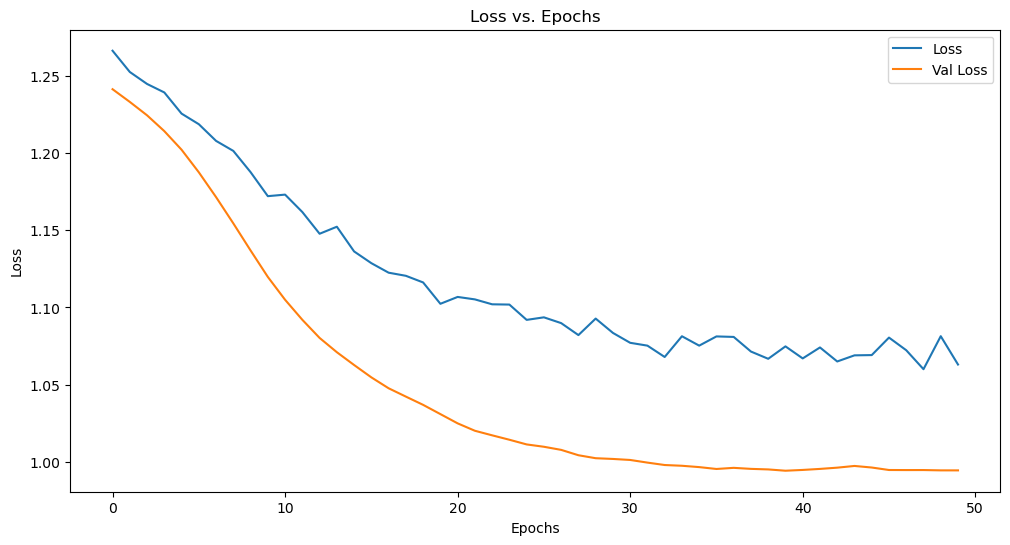

In [30]:
# Plotting the loss 
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

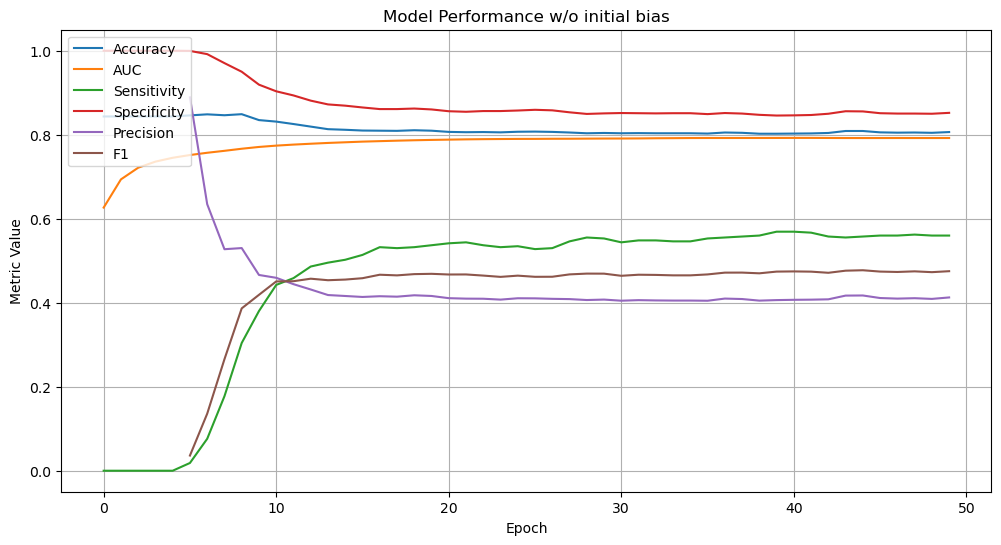

In [31]:
# plot the metrics
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['auc'], label='AUC')
plt.plot(history['sensitivity'], label='Sensitivity')
plt.plot(history['specificity'], label='Specificity')
plt.plot(history['precision'], label='Precision')
plt.plot(history['f1'], label='F1')
plt.title('Model Performance w/o initial bias')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [31]:
# save the model
# torch.save(model.state_dict(), '/Users/panpeter/Desktop/PhD_Learning/Independent Studies/dropout/05_trained_models/14_NN_3L32168_BCEweight_1031.pt')

In [32]:
# predict the test set
model.eval()
with torch.no_grad():
    test_predictions = []
    test_labels = []
    test_predictions_prob = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        # 2023.10.31 using the sigmoid function to convert the output to probability
        predictions_prob = torch.sigmoid(outputs).squeeze()
        predictions = (predictions_prob > params['threshold']).float().squeeze()
        # predictions = (outputs > 0.6).float().squeeze()
        # predictions = (outputs > 0.2).float().squeeze()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())
        # change the output to probability
        test_predictions_prob.extend(predictions_prob.squeeze().tolist())
    accuracy = accuracy_score(test_labels, test_predictions)
    auc = roc_auc_score(test_labels, test_predictions_prob)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (sensitivity * precision) / (sensitivity + precision)

In [33]:
# print the metrics
print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')
print(f'Precision: {precision}')
print(f'F1: {f1}')
# print the confusion matrix
print(f'Confusion Matrix: \n{confusion_matrix(test_labels, test_predictions)}')

Accuracy: 0.7135852321892125
AUC: 0.7879525637828045
Sensitivity: 0.7255985267034991
Specificity: 0.7113543091655267
Precision: 0.3182552504038772
F1: 0.442448062886019
Confusion Matrix: 
[[2080  844]
 [ 149  394]]


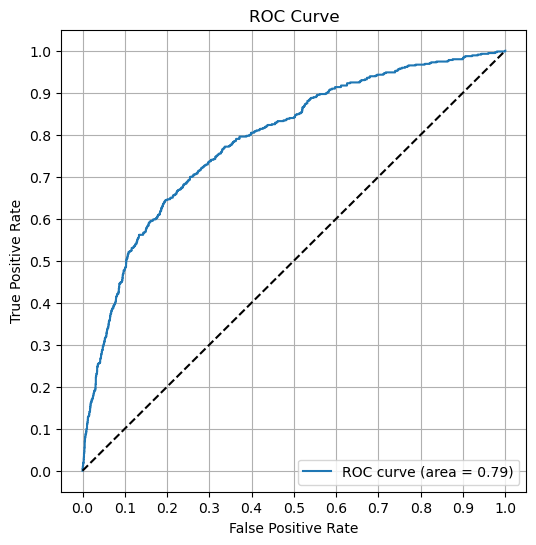

In [34]:
# plot the AUC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
# add the grid on the plot
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plot the x and y interval 0.1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
# torch.save(model.state_dict(), '../05_trained_models/15_NN_3L32168_BCEweight_1109.pt')

In [36]:
# get the fpr, tpr, thresholds for plotting the roc curve later
fpr_nn, tpr_nn, thresholds_nn = roc_curve(test_labels, test_predictions_prob)
# save the fpr, tpr, thresholds to csv file
df_nn = pd.DataFrame({'fpr_nn': fpr_nn, 'tpr_nn': tpr_nn, 'thresholds_nn': thresholds_nn})
df_nn.to_csv('../03_outputs/02_tables/nn_roc_data0506.csv', index=False)

In [72]:
# attach the predicted probability to the test_copy
test_copy['y_pred_prob'] = test_predictions_prob

In [73]:
# save the test_copy to csv file
if drop_protected == False:
    test_copy.to_csv('../03_outputs/02_tables/11_NN_outcome_w_procted_1111_blind.csv', index=False)
else:
    test_copy.to_csv('../03_outputs/02_tables/11_NN_outcome_wo_procted_1111_blind.csv', index=False)

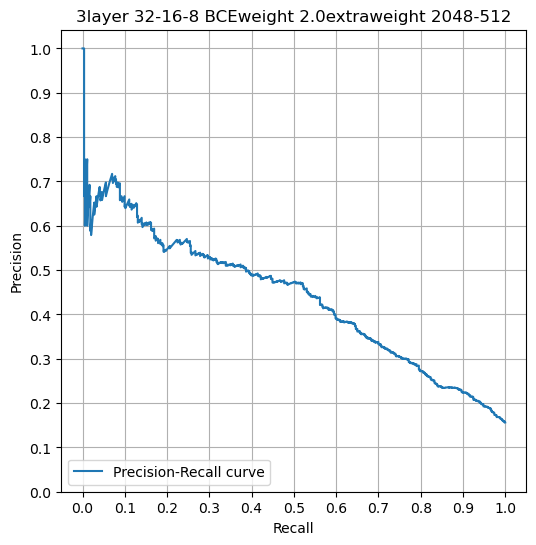

In [35]:
# plot the precision-recall curve

precision, recall, thresholds = precision_recall_curve(test_labels, test_predictions_prob)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
# add the grid on the plot
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
# plot the x and y interval 0.1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('3layer 32-16-8 BCEweight 2.0extraweight 2048-512')
plt.legend(loc='lower left')
plt.show()